**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 2: Machine Learning*

# Identification

Name: Cole Stevens<br/>
Student Number: 300171413

Name: Mikaela Dobie<br/>
Student Number: 300164161

# 1. Exploratory Analysis

## Data Exploration

In this assignment, we will utilize the Diabetes Prediction Dataset, accessible via [Diabetes Prediction Dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data). To mitigate the complexity associated with Kaggle's login requirement, the dataset has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a2](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a2)

You can access and read the dataset directly from this GitHub repository in your Jupyter notebook.

In [47]:
# Importing important libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV


1. **Load the dataset and provide a summary of its structure**:

    - Describe the features (columns), their data types, and the target variable.

The features from the Diabetes Prediction Dataset are as follows:

    1. gender (object/string): a category representative of the individual's biological sex.
    2. age (float): a number representing the individual's age.
    3. hypertension (int): a binary category that determines if the individual has high blood pressure.
    4. heart_disease (int): a binary category that determines if the individual has heart disease.
    5. smoking_history (object/string): a category representative of the individual's history with smoking.
    6. bmi (float): a number representing the individual's bmi.
    7. HbA1c_level (float): a number representing the individual's average blood sugar levels.
    8. blood_glucose_level (int): a number representing the amount of glucose in the individual's blood stream.
    9. diabetes (int): a binary category that determines if the individual has diabetes.
    
The target variable is diabetes, since it is a categorical feature that indicates if the individual who is represented on each row has diabetes or not. This is important (obviously) since the purpose of the dataset is to predict given other medical information about the patient if they have diabetes.

In [36]:
# Loading the dataset
df = pd.read_csv("https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a2/diabetes_prediction_dataset.csv")

# Printing out the dataframe's info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


2. **Feature Distribution Analysis**:

    - Examine the distribution of each feature using appropriate visualizations such as histograms and boxplots. Discuss insights gained, including the presence of outliers.

We will use box-plots to represent the numeric/continuous data, since it will allow us to detect outliers and give us statistics pertaining to the feature, such as the min, max, and median. Histograms will be used to represent the categorical data since outliers aren't as relevant, and they allow us to view the distribution of the classes.

For both of the binary categorical features, the positive result (1) is far less likely to show up than the negative result (0). This is to be expected, since if this data is based off a random survey of a population, a majority of people don't suffer from things like hypertension or heart disease. However, this imbalance could prove to be a problem later on down the road, since the model may end up picking the majority class more often than it should.

For the multi-class categorical features, we can see that there are more females included in the data than males. Furthermore, in the smoking history feature, most people have either never had a history with smoking, or just didn't provide an answer. The minority classes include 'current,' 'former,' 'ever,' and 'not current.' 'ever' may be something to look out for in preprocessing, since the official kaggle site doesn't list 'ever' as a smoking history category -- perhaps it is a typo and should be 'never?'

For the numeric, box-plot features, we notice that there aren't a ton of outliers for the age feature. We have a minimum age of what appears to be close to 0 (most likely a newborn, if not a mistaken input), and a maximum age of around 80. Both of these numbers are realistically possible. The median age being around 40 suggests that most of the individuals being surveyed are middle-aged. The BMI boxplot box is quite narrow, with most of the values being between 20 and 30. However, there are a ton of outliers in this chart, suggesting that there are many individuals with low and high BMIs. The HbA1c Level chart shows that most values fall between a 5 or 6, with a few outliers in the higher range. Since these outliers are in the higher range, this could potentially give us a hint as to which blood sugar levels are indicative of diabetes. Finally, the blood glucose chart has the median between 125 and 150, but there are still a few higher-end outliers. Since hyperglycemia is a thing, it doesn't necessarily mean we should disqualify these outlier points from consideration.

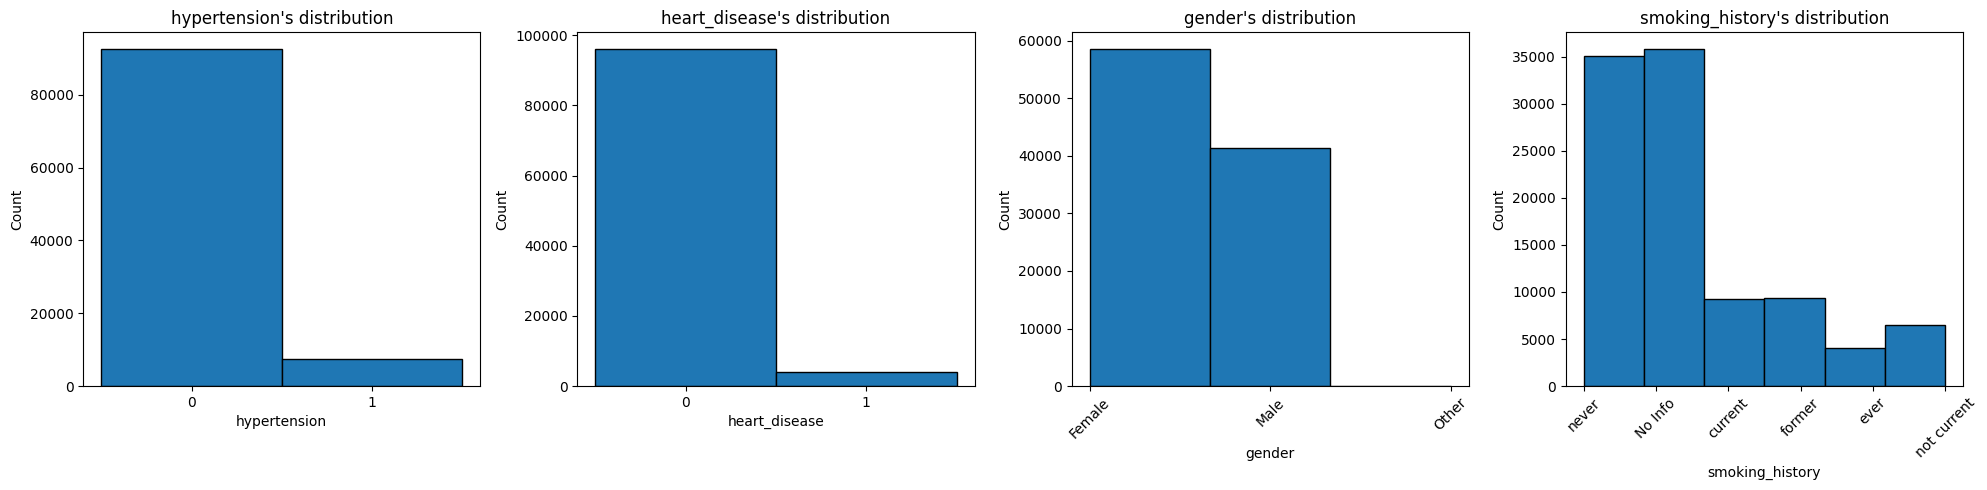

In [37]:
# List of discrete columns and continuous columns
discrete_features = ['hypertension', 'heart_disease', 'gender', 'smoking_history']
continuous_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Creating a 1x4 grid to show off the discrete features
fig_dsc, axes_dsc = plt.subplots(1, 4, figsize=(20, 5))
for i, col in enumerate(discrete_features): 
    if i < 2: # The first 2 entries in discrete_features are binary (0, 1)
        axes_dsc[i].hist(df[col], bins=[-0.5, 0.5, 1.5], edgecolor='black')
        axes_dsc[i].set_xticks([0,1])
    else: # The last 2 entries in discrete_features are multi-class
        axes_dsc[i].hist(df[col], bins=df[col].nunique(), edgecolor='black')
        axes_dsc[i].set_xticks(range(df[col].nunique()))
        axes_dsc[i].set_xticklabels(df[col].unique(), rotation=45)
    axes_dsc[i].set_title(f"{col}'s distribution")
    axes_dsc[i].set_xlabel(col)
    axes_dsc[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

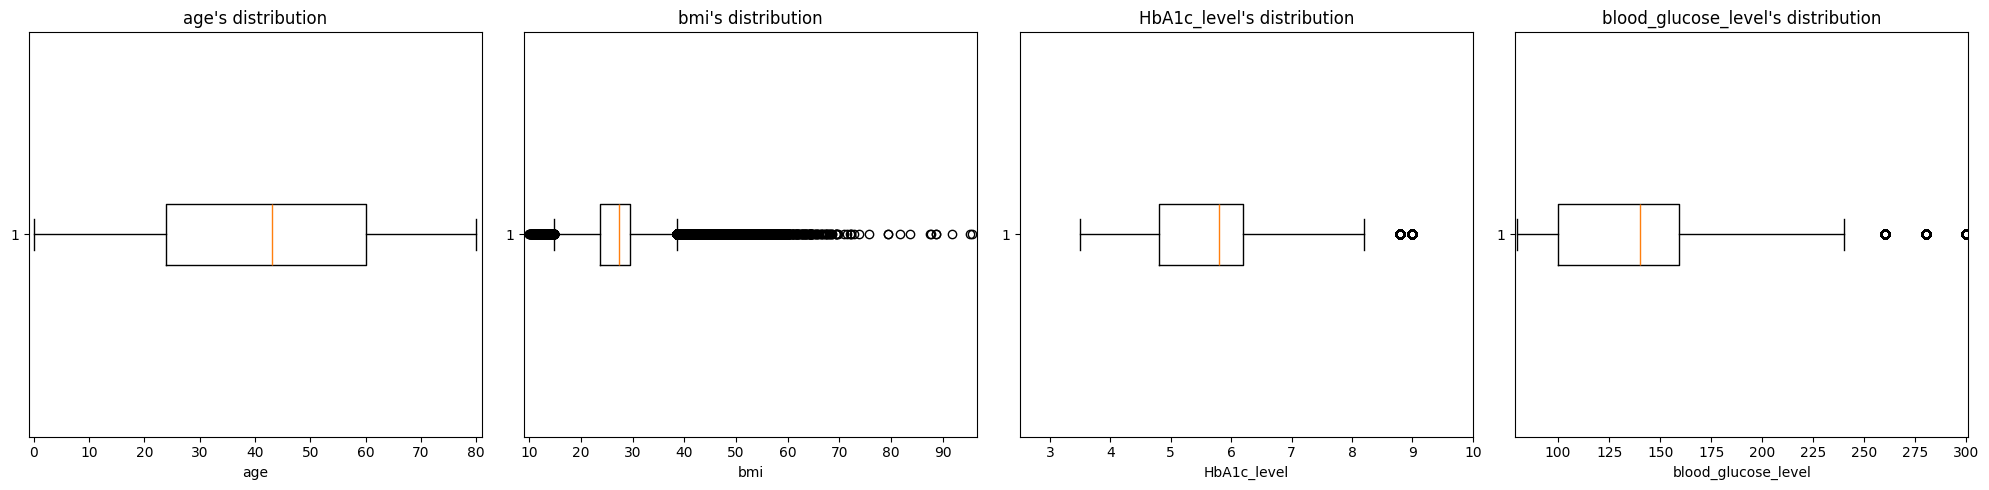

In [38]:
# Creating a 1x4 grid to show off the continuous features
fig_cont, axes_cont = plt.subplots(1, 4, figsize=(20, 5))
for i, col in enumerate(continuous_features):
    axes_cont[i].boxplot(df[col], vert=False)
    axes_cont[i].set_title(f"{col}'s distribution")
    axes_cont[i].set_xlabel(col)
    axes_cont[i].set_xlim(df[col].min()-1, df[col].max()+1)
plt.tight_layout()
plt.show()

3. **Target Variable Distribution**:

    - Analyze the distribution of the target variable to identify class imbalances. Use bar plots to visualize the class frequencies.

Much like the other two binary class features, the positive case is significantly lower than the negative case. This could potentially be a problem later on down the road, since the model may end up picking the majority class (0) more often than it should, simply because the majority of cases say that the individual tests negative for diabetes. We should be sure to have our model consider all classes.

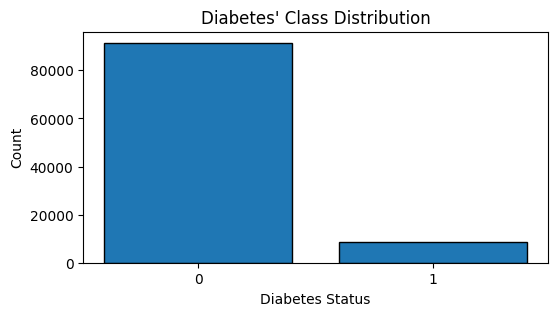

In [39]:
# Creating a bar plot to visualize the diabetes feature's class frequencies
plt.figure(figsize=(6,3))
plt.bar(['0', '1'], df['diabetes'].value_counts(), edgecolor='black')
plt.xlabel("Diabetes Status")
plt.ylabel("Count")
plt.title("Diabetes' Class Distribution")
plt.show()

4. **Data Splitting**:

    - Split the dataset into training (80%) and test (20%) sets using the holdout method.

    - Ensure that this split occurs before any preprocessing to avoid data leakage.

In [40]:
# Removing the target feature from the rest of the data
x = df.drop('diabetes', axis=1)
y = df['diabetes']

# Splitting the data into a training and a testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

## Data Pre-Processing

5. **Categorical Variable Encoding**:

    - Encode any categorical variables. Justify the chosen method.

Using one hot encoding, we encoded the two object type categories: Gender and Smoking_history. Though smoking history could be considered ordered, it has too much unconfirmed data thus we are using the one-hot encoder to ensure bias will not exist
Hypertension and heart_disease are technically already encoded since it's binary. and the others are all already numeric.

In [41]:
# Encoding the non-ordered categories using the One-Hot Encoder: Gender, Smoking History (Since there is an uneven distribution, and a lot of no info)

# Initializing the OneHotEncoder and fitting it on the training set
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(x_train[['gender', 'smoking_history']])

# Applying the encoder on the training and test set columns
x_train_encoded = encoder.transform(x_train[['gender', 'smoking_history']])
x_test_encoded = encoder.transform(x_test[['gender', 'smoking_history']])

# Since the result is an array, we convert the encoded sets back to dataframes
x_train_encoded_df = pd.DataFrame(x_train_encoded, columns=encoder.get_feature_names_out(['gender', 'smoking_history']))
x_test_encoded_df = pd.DataFrame(x_test_encoded, columns=encoder.get_feature_names_out(['gender', 'smoking_history']))

# Resetting the index for the dataframes to prevent NaNs from showing up
x_train_encoded_df.reset_index(drop=True, inplace=True)
x_test_encoded_df.reset_index(drop=True, inplace=True)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

# Removing the non-encoded columns from our original train/test dataframes, and adding the encoded ones
x_train = x_train.drop(['gender', 'smoking_history'], axis=1)
x_train = pd.concat([x_train, x_train_encoded_df], axis=1)
x_test = x_test.drop(['gender', 'smoking_history'], axis=1)
x_test = pd.concat([x_test, x_test_encoded_df], axis=1)

print(x_train.info())
print(x_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          80000 non-null  float64
 1   hypertension                 80000 non-null  int64  
 2   heart_disease                80000 non-null  int64  
 3   bmi                          80000 non-null  float64
 4   HbA1c_level                  80000 non-null  float64
 5   blood_glucose_level          80000 non-null  int64  
 6   gender_Female                80000 non-null  float64
 7   gender_Male                  80000 non-null  float64
 8   gender_Other                 80000 non-null  float64
 9   smoking_history_No Info      80000 non-null  float64
 10  smoking_history_current      80000 non-null  float64
 11  smoking_history_ever         80000 non-null  float64
 12  smoking_history_former       80000 non-null  float64
 13  smoking_history_

Normalization/Standardization of Numerical Features:

- Normalize or standardize numerical features if necessary. Describe the technique used (e.g., Min-Max scaling, StandardScaler) and explain why it is suitable for this dataset.

- Ensure that this technique is applied only to the training data, with the same transformation subsequently applied to the test data without fitting on it.

We know that typically Normalization will rescale a set of values to be in a range of [0,1] or [-1,1]. This would be fine for the age feature, since there aren't any real outliers, as evidenced by the box-plot chart generated earlier. The other numeric features, bmi, HbA1c_level, and blood_glucose_level do have outliers (seen in box-plots), so standardization would be the wisest choice. 

In [42]:
# Step 1: Initialize the Scalers
normalizer = MinMaxScaler()
standardizer = StandardScaler()

# Step 2: Fitting the Scalers to the Training Data
x_train[['age']] = normalizer.fit_transform(x_train[['age']])
x_train[['bmi', 'HbA1c_level', 'blood_glucose_level']] = standardizer.fit_transform(x_train[['bmi', 'HbA1c_level', 'blood_glucose_level']])

# Step 3: Applying the now fitted Scalers to the Testing Data
x_test[['age']] = normalizer.transform(x_test[['age']])
x_test[['bmi', 'HbA1c_level', 'blood_glucose_level']] = standardizer.transform(x_test[['bmi', 'HbA1c_level', 'blood_glucose_level']])

print(x_train)
print(x_test)

            age  hypertension  heart_disease       bmi  HbA1c_level  \
0      1.000000             1              0  0.000472     0.908249   
1      0.236737             0              0 -0.321772    -0.959680   
2      0.449449             0              0 -0.205824     1.001645   
3      0.436937             0              0 -0.585289     0.441267   
4      0.374374             0              0 -0.707259    -0.492698   
...         ...           ...            ...       ...          ...   
79995  0.486987             0              0  0.747355    -0.679491   
79996  0.537037             0              0  0.000472     0.628060   
79997  0.649650             1              0  0.000472     0.254474   
79998  0.061562             0              0 -1.752293     0.628060   
79999  0.049049             0              0  0.000472    -1.426662   

       blood_glucose_level  gender_Female  gender_Male  gender_Other  \
0                 0.170207            1.0          0.0           0.0   
1  

## Model Development & Evaluation

7. **Model Development**:

    - Implement the machine learning models covered in class: Decision Trees, K-Nearest Neighbors (KNN), and Logistic Regression. Use the default parameters of scikit-learn as a baseline for training each model.

In [43]:
# Code cell

## 1. Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42) #Default Parameter
dt_model.fit(x_train, y_train)
y_pred_dt = dt_model.predict(x_test)
print("\nDecision Tree Performance:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

## 2. K-Nearest Neighbors (KNN) Classifier
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
y_pred_knn = knn_model.predict(x_test)
print("\nK-Nearest Neighbours Performance:")
print(classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

## 3. Logistic Regression
lr_model = LogisticRegression(random_state=42) #Default Parameter
lr_model.fit(x_train, y_train)
y_pred_lr = lr_model.predict(x_test)
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18300
           1       0.70      0.74      0.72      1700

    accuracy                           0.95     20000
   macro avg       0.84      0.85      0.85     20000
weighted avg       0.95      0.95      0.95     20000

Accuracy: 0.95095

K-Nearest Neighbours Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.90      0.64      0.74      1700

    accuracy                           0.96     20000
   macro avg       0.93      0.81      0.86     20000
weighted avg       0.96      0.96      0.96     20000

Accuracy: 0.9629

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.86      0.64      0.73      1700

    accuracy                           0.96     20

8. **Model Evaluation**:

    - Use cross-validation to evaluate each model, justifying your choice of the number of folds.

    - Assess the models using metrics such as precision, recall, and F1-score.

    The two most commonly used folds are k=5 and k=10. We show the results of both k values.
    The number of folds that gave better results was k = 10.

In [44]:
# Code cell

k = 5  # 5-fold cross-validation is commonly used
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Define Models used

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}
# Define socing scheme

scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Evaluate each model using cross-validation
print(f"For k = 5 \n")
for name, model in models.items():
    print(f"Evaluating {name}...")
    scores = cross_validate(model, x_train, y_train, cv=cv, scoring=scoring)
    
    print(f"Precision: {scores['test_precision'].mean():.3f} ± {scores['test_precision'].std():.3f}")
    print(f"Recall:    {scores['test_recall'].mean():.3f} ± {scores['test_recall'].std():.3f}")
    print(f"F1-score:  {scores['test_f1'].mean():.3f} ± {scores['test_f1'].std():.3f}\n")

k = 10  # 10-fold cross-validation is commonly used
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

print(f"For k = 10 \n")
for name, model in models.items():
    print(f"Evaluating {name}...")
    scores = cross_validate(model, x_train, y_train, cv=cv, scoring=scoring)
    
    print(f"Precision: {scores['test_precision'].mean():.3f} ± {scores['test_precision'].std():.3f}")
    print(f"Recall:    {scores['test_recall'].mean():.3f} ± {scores['test_recall'].std():.3f}")
    print(f"F1-score:  {scores['test_f1'].mean():.3f} ± {scores['test_f1'].std():.3f}\n")

For k = 5 

Evaluating Decision Tree...
Precision: 0.701 ± 0.008
Recall:    0.738 ± 0.008
F1-score:  0.719 ± 0.008

Evaluating K-Nearest Neighbors...
Precision: 0.910 ± 0.003
Recall:    0.629 ± 0.007
F1-score:  0.743 ± 0.005

Evaluating Logistic Regression...
Precision: 0.869 ± 0.011
Recall:    0.628 ± 0.013
F1-score:  0.729 ± 0.010

For k = 10 

Evaluating Decision Tree...
Precision: 0.707 ± 0.018
Recall:    0.741 ± 0.015
F1-score:  0.723 ± 0.016

Evaluating K-Nearest Neighbors...
Precision: 0.910 ± 0.011
Recall:    0.633 ± 0.015
F1-score:  0.746 ± 0.011

Evaluating Logistic Regression...
Precision: 0.868 ± 0.011
Recall:    0.628 ± 0.016
F1-score:  0.729 ± 0.012



## Hyperparameter Optimization

9. **Exploration and Performance Evaluation:**

    - Investigate the impact of varying hyperparameter values on the performance of each model.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Display the results in a tabular or graphical format (e.g., line charts, bar charts) to effectively demonstrate the influence of hyperparameter variations on model performance.

    - Specify the default values for each hyperparameter tested.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

Best DecisionTree hyperparameter configuration:  {'criterion': 'entropy', 'max_depth': 10}
Best DecisionTree hyperparameter score:  0.9693224400565112


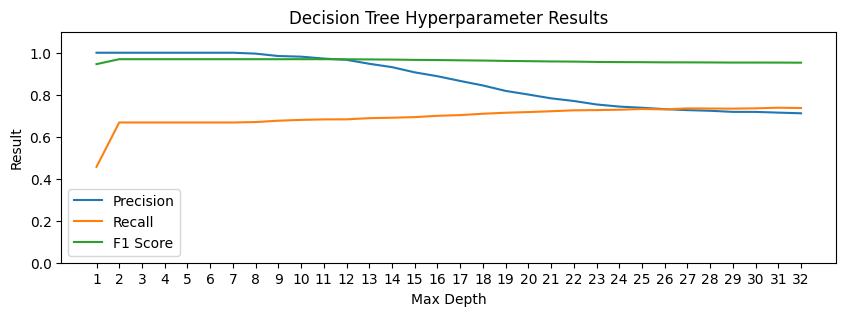

In [45]:
# Code cell
# Employing a Grid Search strategy to evaluate all combinations of hyperparameters for the DecisionTree
decision_tree_gridsearch = GridSearchCV(
    estimator = DecisionTreeClassifier(),
    param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': range(1, 33)}, # 2^0 to 2^5 
    scoring = ['precision', 'recall', 'f1_weighted'],
    refit = 'f1_weighted',
    cv = 10
)

# Fitting the gridsearch to our training set
decision_tree_gridsearch.fit(x_train, y_train)

# Generating a dataframe of the Grid Search results
gridsearch_results = pd.DataFrame(decision_tree_gridsearch.cv_results_)

# Displaying the best configuration of hyperparameters
print("Best DecisionTree hyperparameter configuration: ", decision_tree_gridsearch.best_params_)
print("Best DecisionTree hyperparameter score: ", decision_tree_gridsearch.best_score_)

# Graphing out the best criterion scores across each depth value
gridsearch_results = gridsearch_results[gridsearch_results['param_criterion'] == decision_tree_gridsearch.best_params_['criterion']]

# Getting our x-axis data
max_depths = gridsearch_results['param_max_depth'].astype(int).unique()

# Getting the precision, recall, and f1 scores (for the y-axis)
precision = gridsearch_results['mean_test_precision']
recall = gridsearch_results['mean_test_recall']
f1 = gridsearch_results['mean_test_f1_weighted']

# Creating the line chart
plt.figure(figsize=(10, 3))

# Plotting out the results
plt.plot(max_depths, precision, label='Precision')
plt.plot(max_depths, recall, label='Recall')
plt.plot(max_depths, f1, label='F1 Score')

# Setting the titles and labels for the x and y axes
plt.title('Decision Tree Hyperparameter Results')
plt.xlabel('Max Depth')
plt.ylabel('Result')

# Setting the limits for the x and y axes
plt.xticks(max_depths)
plt.ylim(0, 1.1)

# Since there are multiple lines, we add a legend
plt.legend()

# Showing the plot
plt.show()

## Analysis of Results

10. **Model Comparison**:

    - Compare the results obtained from each model.

    - Discuss observed differences in model performance, providing potential explanations. Consider aspects such as model complexity, data imbalance, overfitting, and the impact of parameter tuning on overall results.

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

    - Train the recommended model(s) using the optimal parameter values identified from the parameter optimization step. Subsequently, apply the trained model to the test data. Document your observations comprehensively. Specifically, evaluate whether the results derived from cross-validation are consistent with those obtained from the test set.


| **Model**            | **Precision** | **Recall** | **F1-Score** |  
|----------------------|---------------|------------|-------------|  
| Decision Tree        | 0.707 ± 0.018 | 0.741 ± 0.015 | 0.723 ± 0.016 |  
| K-Nearest Neighbors  | 0.910 ± 0.011 | 0.633 ± 0.015 | 0.746 ± 0.011 |  
| Logistic Regression  | 0.868 ± 0.011 | 0.628 ± 0.016 | 0.729 ± 0.012 |

---

## **Analysis of Model Outputs**

1. **Decision Tree**  
   - The higher recall indicates that the Decision Tree captures more true positives, but its precision is lower, suggesting a higher false positive rate.
   - This model might perform better when recall is more critical, but otherwise is prone to overfitting.

2. **K-Nearest Neighbors (KNN)**  
   - KNN has the highest precision, meaning it makes very few false positive predictions, but it sacrifices recall.
   - This suggests it performs well when minimizing false alarms is a priority but might struggle with imbalanced data or rare positive cases.
   - Parameter tuning (changing the number of neighbours) can improve its recall.

3. **Logistic Regression**  
   - Logistic Regression provides a good balance between precision and recall, with a better F1-score than Decision Tree but is slightly lower than KNN.
   - It is less prone to overfitting and easier to interpret than the other models. 


**Recommended Model: Decision Tree**  

  - Balanced performance across precision, recall, and F1-score, and since we are not trying to optimize one value the most its the most logical decision.
  - It is easy to implement and interpret.

However, KNN could be considered if false positives must be minimized, and Logistic Regression is not a bad choice otherwise.
There were no bad options just one was better than the others




In [48]:
# Code cell

best_params = decision_tree_gridsearch.best_params_
best_model = decision_tree_gridsearch.best_estimator_

print("Best Parameters:", best_params)

# Predict on the test data with the best model
y_pred = best_model.predict(x_test)

# Evaluate the model on the test data

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Test Set Performance:")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
 

Best Parameters: {'criterion': 'entropy', 'max_depth': 10}
Test Set Performance:
Precision: 0.976
Recall:    0.687
F1-Score:  0.806

Confusion Matrix:
[[18271    29]
 [  532  1168]]


## 2. Documentation of Exploratory Analysis

The report should comprehensively document the entire process followed during this assignment. The Jupyter Notebook must include the following:

- Your name(s), student number(s), and a report title.
- Explain how the tasks have been split between the members. How did you make sure that both students achieve the learning outcomes? 
- A section for each step of the exploratory analysis, containing the relevant Python code and explanations or results.
  - For sections requiring Python code, include the code in a cell.
  - For sections requiring explanations or results, include these in a separate cell or in combination with code cells.
- Ensure logical separation of code into different cells. For example, the definition of a function should be in one cell and its execution in another. Avoid placing too much code in a single cell to maintain clarity and readability.
- The notebook you submit must include the results of the execution, complete with graphics, ensuring that the teaching assistant can grade the notebook without needing to execute the code.


Exploratory Analysis Dicussion of Diabetes Dataset

By: Cole Stevens [300171413] and Mikaela Dobie [300164161]

For this assignment, Cole took the lead and did 1-4, both Cole and Mikaela worked on 5 and 6, and Mikaela worked on 7 and 8. {insert other numbers when done}

The work was dicussed as we both worked on parts that needed to be expanded on by the other. Both of us are sure to achieve the leaning outcomes as we had good communication while completing the task and 

# Resources

https://turcotte.xyz/teaching/csi-4106/
https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html
https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html